In [1]:
import os, importlib, sys, time

In [2]:
import itertools
from tqdm import tqdm

In [3]:
import numpy as np
import scipy.sparse as sparse
import matplotlib.pyplot as plt
import pandas as pd
import pyarrow

In [4]:
import KECENI

# load data

In [5]:
data_dir = 'data'
save_dir = 'result'

In [6]:
data_network = pd.read_feather('%s/network.feather'%(data_dir))
data_latent = pd.read_feather('%s/latent.feather'%data_dir)

In [7]:
data_network

,row,col
0,1,244
1,2,416
2,2,536
3,2,540
4,2,726
...,...,...
3391,999,880
3392,1000,352
3393,1000,357
3394,1000,807


In [8]:
n_node = len(data_latent); n_node

1000

In [9]:
Adj = sparse.csr_matrix((
    np.full(len(data_network), True), 
    (np.array(data_network.row)-1, np.array(data_network.col)-1)
)).toarray()

In [10]:
G = KECENI.Graph(Adj)

# hyperparameters

In [11]:
from hyperparams import delta, HyperAlpha

# counterfactual of interest

In [12]:
i0 = 17

In [15]:
T0s_1 = np.zeros(n_node); T0s_1[G.N1(i0)[::2]] = 1
T0s_0 = T0s_1.copy(); T0s_0[i0] = 0

In [16]:
T0s_0[G.N1(i0)], T0s_1[G.N1(i0)]

(array([0., 0., 1., 0., 1.]), array([1., 0., 1., 0., 1.]))

In [17]:
i0s = np.array([i0])
T0s = np.array([T0s_0, T0s_1])

# groundtruth

In [20]:
YTR_0, YTR_1 = (-1, 1)
YTR_d = YTR_1 - YTR_0

In [21]:
YTR_0, YTR_1, YTR_d

(-1, 1, 2)

# estimation

In [25]:
alphas_mu = np.linspace(0, 1, 11)
alphas_pi = np.linspace(0, 1, 11)

In [26]:
n_sim = 80

## - load simulation

In [27]:
lamdas = np.linspace(0, 20, 21)[1:]

In [29]:
ids_cv = np.zeros(alphas_mu.shape + alphas_pi.shape + (n_sim,), dtype=int)

In [30]:
YGs_0 = np.zeros(alphas_mu.shape + alphas_pi.shape + (n_sim,))
YGs_1 = np.zeros(alphas_mu.shape + alphas_pi.shape + (n_sim,))
YGs_d = np.zeros(alphas_mu.shape + alphas_pi.shape + (n_sim,))
YDRs_0 = np.zeros(alphas_mu.shape + alphas_pi.shape + (n_sim,))
YDRs_1 = np.zeros(alphas_mu.shape + alphas_pi.shape + (n_sim,))
YDRs_d = np.zeros(alphas_mu.shape + alphas_pi.shape + (n_sim,))

In [39]:
for i_sim in tqdm(np.arange(n_sim), desc='SIM', smoothing=0, leave=None, position=0):
    locals().update(np.load('%s/result_%.3d.npz'%(save_dir,i_sim)))
    YGs_0[...,i_sim] = result_G[...,0]; YGs_1[...,i_sim] = result_G[...,1]
    YGs_d[...,i_sim] = YGs_1[...,i_sim] - YGs_0[...,i_sim]
    YDRs_0[...,i_sim] = result_AIPW[np.arange(len(alphas_mu))[:,None],np.arange(len(alphas_pi)),id_cv,0]
    YDRs_1[...,i_sim] = result_AIPW[np.arange(len(alphas_mu))[:,None],np.arange(len(alphas_pi)),id_cv,1]
    YDRs_d[...,i_sim] = YDRs_1[...,i_sim] - YDRs_0[...,i_sim]

SIM: 100%|██████████| 80/80 [00:00<00:00, 1226.43it/s]


## - G estimate

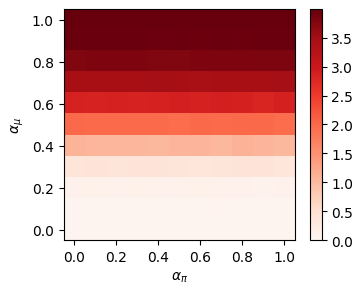

In [41]:
plt.figure(figsize=(4,3))
plt.imshow(np.mean((YGs_d - YTR_d)**2, -1), 'Reds', vmin=0, origin='lower')
plt.yticks(np.arange(len(alphas_mu))[::2], labels=['%.1f'%alpha for alpha in alphas_mu[::2]])
plt.xticks(np.arange(len(alphas_pi))[::2], labels=['%.1f'%alpha for alpha in alphas_pi[::2]])
plt.xlabel(r'$\alpha_\pi$'); plt.ylabel(r'$\alpha_\mu$'); plt.colorbar()

## - KECENI

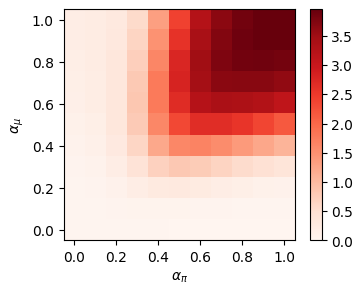

In [43]:
plt.figure(figsize=(4,3))
plt.imshow(np.mean((YDRs_d - YTR_d)**2, -1), 'Reds', vmin=0, origin='lower')
plt.yticks(np.arange(len(alphas_mu))[::2], labels=['%.1f'%alpha for alpha in alphas_mu[::2]])
plt.xticks(np.arange(len(alphas_pi))[::2], labels=['%.1f'%alpha for alpha in alphas_pi[::2]])
plt.xlabel(r'$\alpha_\pi$'); plt.ylabel(r'$\alpha_\mu$'); plt.colorbar()